K-Means is a class of unsupervised machine learning models: clustering algorithms. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.
<br /><br />
Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as k-means clustering, which is implemented in sklearn.cluster.KMeans.
<br /><br />
The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:
<br /><br />
- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.
- Those two assumptions are the basis of the k-means model.

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm.
<br /><br />
The expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    1. E-Step: assign points to the nearest cluster center
    2. M-Step: set the cluster centers to the mean

<br />
Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.
<br /><br />
The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

### Caveats of expectation–maximization
#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results.
<br /><br />
For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the n_init parameter, which defaults to 10).
<br /><br />
#### The number of clusters must be selected beforehand
Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters.
<br /><br />
Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive,  is called [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).
<br /><br />
Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)) or which can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the sklearn.cluster submodule)
<br /><br />
#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.
<br /><br />
In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries.
<br /><br />
#### k-means can be slow for large numbers of samples
Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in sklearn.cluster.MiniBatchKMeans. The interface for this is the same as for standard KMeans.

### Example1: k-means on digits

Here we will attempt to use k-means to try to identify digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.
<br /><br />
We will start by loading the digits and then finding the KMeans clusters. The digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image.
<br /><br />
Dataset: sklearn.datasets

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in [In-Depth: Manifold Learning](https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html)) to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.

In [2]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

In [7]:
from sklearn.cluster import KMeans

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)
kmeans.cluster_centers_.shape

(10, 2)

The result is 10 clusters in 2 dimensions. Notice that the cluster centers themselves are 2-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.

Even without the labels, KMeans is able to find clusters whose centers are recognizable digits, because k-means knows nothing about the identity of the cluster. We can fix this by matching each learned cluster label with the true labels found in them.

In [14]:
from scipy.stats import mode
import numpy as np

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data.

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.9371174179187535

With just a simple k-means algorithm, we discovered the correct grouping for 90% of the input digits. Let's check the confusion matrix for this.

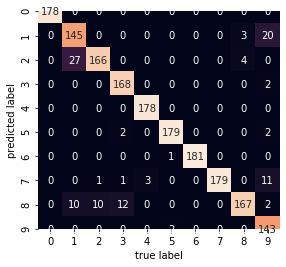

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This shows that using k-means, we can essentially build a digit classifier without reference to any known labels.

This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

### Example2: k-means for color compression

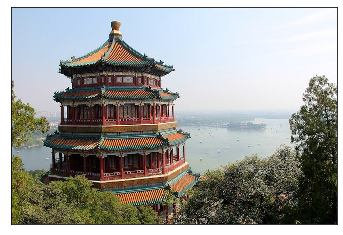

In [32]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255

In [33]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1

In [34]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency

In [36]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

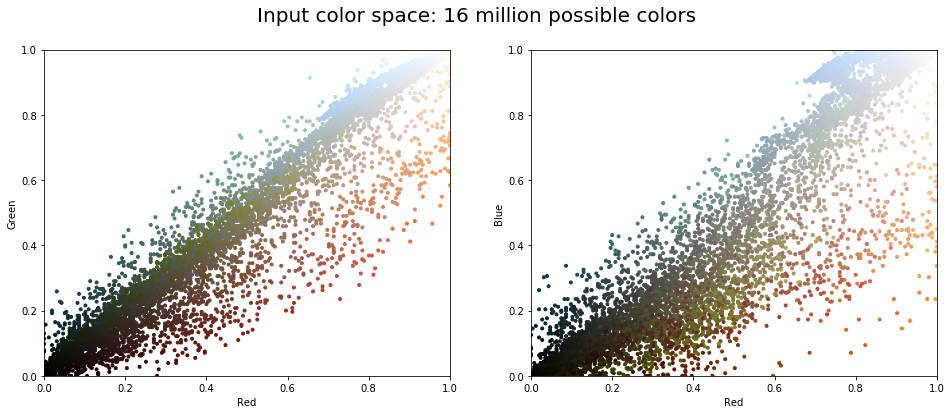

In [37]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm

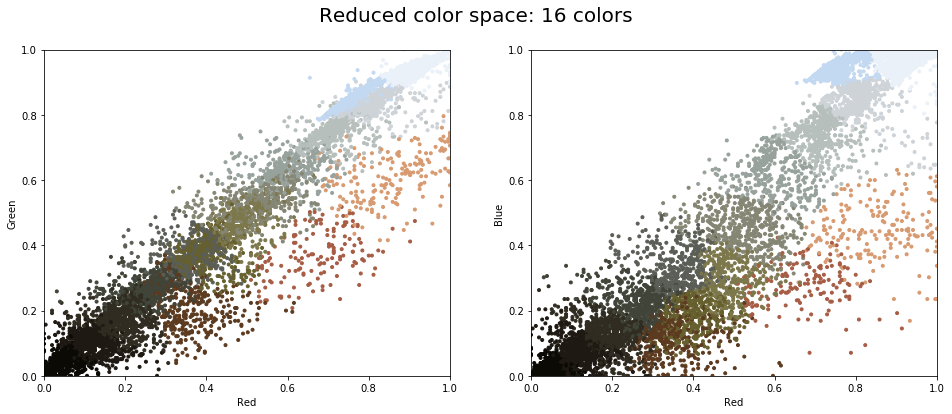

In [38]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this

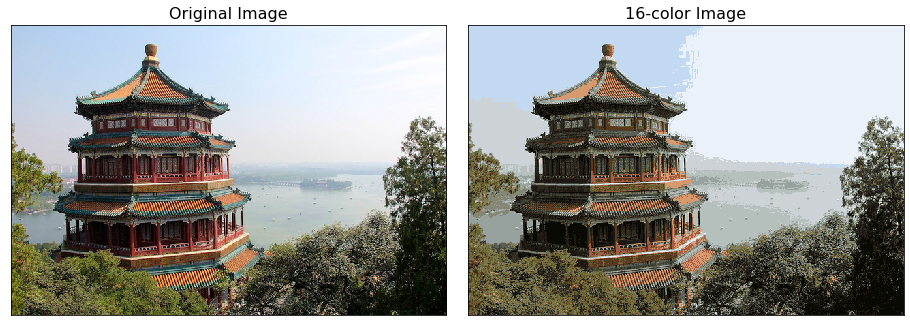

In [39]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);